In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score

from IPython.display import display
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
import warnings
warnings.filterwarnings("ignore")
    
%matplotlib inline

# 匯入資料集

In [2]:
data = pd.read_excel('C:/Users/Administrator/paper/108_recruit_train.xlsx')
data = data[data['highest_school_level']!='F']
data['highest_school_level'] = data['highest_school_level'].astype('int')
data = data.drop(['interview','second_interview','relabel'], axis=1)
data.head()

,id,sex,apply_age,marriage,highest_education,highest_graduation,loan,loan_status,military_status,aboriginal,height,weight,nationality,highest_school_level,english_level,hired_or_not,bmi,bmi_cagegory
0,R224211691,F,24,0,B,Y,0,1,1,0,162,60,1,3,2.0,0,23,1
1,R223936966,F,28,0,B,Y,1,1,1,0,158,52,1,2,2.0,0,21,1
2,F228161684,F,24,0,B,Y,1,1,1,0,164,70,1,3,2.0,0,26,0
3,O200443001,F,21,0,B,Y,0,1,1,0,152,41,1,5,2.0,0,18,0
4,N225966272,F,22,0,B,I,0,1,1,0,155,45,1,6,3.0,0,19,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1188 entries, 0 to 1201
Data columns (total 18 columns):
id                      1188 non-null object
sex                     1188 non-null object
apply_age               1188 non-null int64
marriage                1188 non-null int64
highest_education       1188 non-null object
highest_graduation      1188 non-null object
loan                    1188 non-null int64
loan_status             1188 non-null int64
military_status         1188 non-null int64
aboriginal              1188 non-null int64
height                  1188 non-null int64
weight                  1188 non-null int64
nationality             1188 non-null int64
highest_school_level    1188 non-null int32
english_level           1188 non-null float64
hired_or_not            1188 non-null int64
bmi                     1188 non-null int64
bmi_cagegory            1188 non-null int64
dtypes: float64(1), int32(1), int64(12), object(4)
memory usage: 171.7+ KB


# 檢視資料集

,sex,hired_or_not
0,F,0.081
1,M,0.095


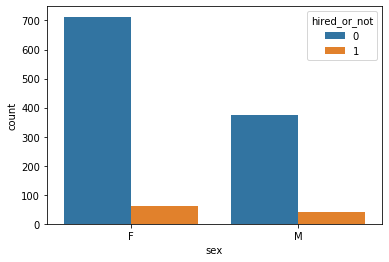

In [4]:
# 性別
sns.countplot(data['sex'], hue=data['hired_or_not'])
display(data[['sex','hired_or_not']].groupby(['sex'], as_index=False).mean().round(3))

,highest_education,hired_or_not
0,B,0.085
1,D,0.000
2,M,0.093


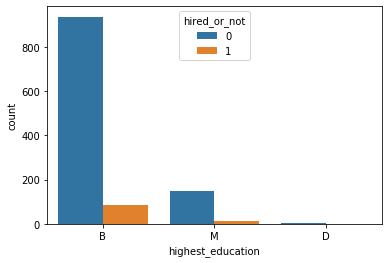

In [5]:
# 最高學歷
sns.countplot(data['highest_education'], hue=data['hired_or_not'])
display(data[['highest_education','hired_or_not']].groupby(['highest_education'], as_index=False).mean().round(3))

,loan,hired_or_not
0,0,0.081
1,1,0.101


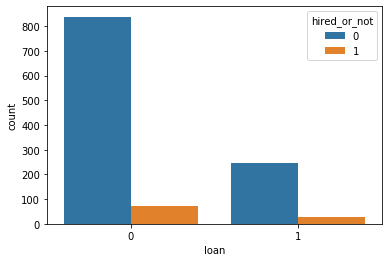

In [6]:
# 借貸狀況
sns.countplot(data['loan'], hue=data['hired_or_not'])
display(data[['loan','hired_or_not']].groupby(['loan'], as_index=False).mean().round(3))

,marriage,hired_or_not
0,0,0.089
1,1,0.063


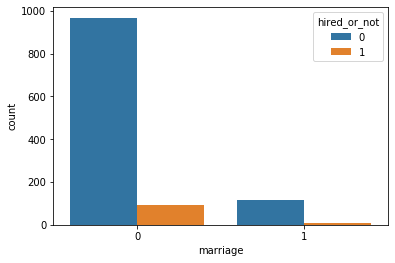

In [7]:
# 婚姻狀況
sns.countplot(data['marriage'], hue=data['hired_or_not'])
display(data[['marriage','hired_or_not']].groupby(['marriage'], as_index=False).mean().round(3))

,bmi_cagegory,hired_or_not
0,0,0.088
1,1,0.085


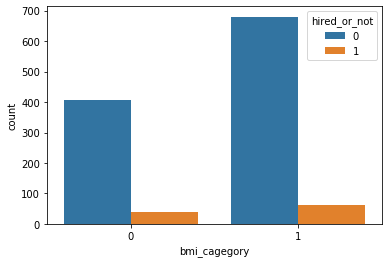

In [8]:
# BMI
sns.countplot(data['bmi_cagegory'], hue=data['hired_or_not'])
display(data[['bmi_cagegory','hired_or_not']].groupby(['bmi_cagegory'], as_index=False).mean().round(3))

In [9]:
mask1 = data['sex'] == 'F'
mask2 = data['hired_or_not'] == 1
mask3 = data['sex'] == 'M'
mask4 = data['hired_or_not'] == 1

print("女性應徵錄取率：", len(data[(mask1 & mask2)]) / len(data[data['sex']=='F']))
print("男性應徵錄取率：", len(data[(mask3 & mask4)]) / len(data[data['sex']=='M']))
print("應徵者女男比：", len(data[data['sex']=='F'])/ len(data[data['sex']=='M']))
print("錄取者女男比：", len(data[(mask1 & mask2)]) / len(data[(mask3 & mask4)]))

女性應徵錄取率： 0.08118556701030928
男性應徵錄取率： 0.09466019417475728
應徵者女男比： 1.883495145631068
錄取者女男比： 1.6153846153846154


In [10]:
print("女性應徵者平均年齡：", data[data['sex']=='F'].apply_age.mean())
print("女性應徵者平均錄取年齡：", data[(mask1 & mask2)].apply_age.mean())
print("男性應徵者平均年齡：", data[data['sex']=='M'].apply_age.mean())
print("男性應徵者平均錄取年齡：", data[(mask3 & mask4)].apply_age.mean())

女性應徵者平均年齡： 26.41623711340206
女性應徵者平均錄取年齡： 25.26984126984127
男性應徵者平均年齡： 27.315533980582526
男性應徵者平均錄取年齡： 26.53846153846154


# 進行訓練

In [11]:
data_train = data.iloc[:,1:-3]
data_hired = data.iloc[:,-3]
data_train = pd.get_dummies(data_train)

In [12]:
data_train.head()

,apply_age,marriage,loan,loan_status,military_status,aboriginal,height,weight,nationality,highest_school_level,english_level,sex_F,sex_M,highest_education_B,highest_education_D,highest_education_M,highest_graduation_D,highest_graduation_I,highest_graduation_Y
0,24,0,0,1,1,0,162,60,1,3,2.0,1,0,1,0,0,0,0,1
1,28,0,1,1,1,0,158,52,1,2,2.0,1,0,1,0,0,0,0,1
2,24,0,1,1,1,0,164,70,1,3,2.0,1,0,1,0,0,0,0,1
3,21,0,0,1,1,0,152,41,1,5,2.0,1,0,1,0,0,0,0,1
4,22,0,0,1,1,0,155,45,1,6,3.0,1,0,1,0,0,0,1,0


In [13]:
data_hired.head()

0    0
1    0
2    0
3    0
4    0
Name: hired_or_not, dtype: int64

In [14]:
df_train, df_test, hired_train, hired_test = train_test_split(data_train, data_hired, test_size = 0.2, random_state = 0)

In [15]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df_train_logistic = sc.fit_transform(df_train)
df_test_logistic = sc.transform(df_test)

In [16]:
logistic_reg = LogisticRegression()

In [17]:
# 進行訓練
logistic_reg.fit(df_train_logistic, hired_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
# 預測
logistic_pred = logistic_reg.predict(df_test_logistic)

In [19]:
# 預測機率
logistic_pred_proba = logistic_reg.predict_proba(df_test_logistic)

In [20]:
# 準確率
accuracy_score(hired_test, logistic_pred)

0.9117647058823529

# 建立測試資料集

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
np.random.seed(1)

In [22]:
n_pop = 1000000
p_male = 0.7

p_job_male, p_job_female = 0.09, 0.05

In [23]:
gender = np.random.choice(['male', 'female'], size=n_pop, p=[p_male, 1 - p_male])

df = pd.DataFrame({'gender' : gender})

df.loc[df.gender == 'male', 'found_job'] = np.random.choice([1, 0], size=len(df.loc[df.gender == 'male']), p=[p_job_male, 1 - p_job_male])
df.loc[df.gender == 'female', 'found_job'] = np.random.choice([1, 0], size=len(df.loc[df.gender == 'female']), p=[p_job_female, 1 - p_job_female])

df['found_job'] = df['found_job'].astype(int)

In [24]:
df.pivot_table(index='gender', columns='found_job', aggfunc='size')

found_job,0,1
gender,,
female,284995,15023
male,636697,63285


In [49]:
mu_job, sigma_job = 25, 8
mu_no_job, sigma_no_job = 35, 10

In [50]:
df.loc[df.found_job == 1, 'age'] = np.floor(np.random.normal(mu_job, sigma_job, len(df.loc[df.found_job == 1])))
df.loc[df.found_job == 0, 'age'] = np.floor(np.random.normal(mu_no_job, sigma_no_job, len(df.loc[df.found_job == 0])))

df['age'] = df['age'].astype(int)

In [51]:
df.groupby('found_job').mean().round(1)

,age
found_job,
0,34.5
1,24.5


In [28]:
class_set = ['A', 'B', 'C']
class_wt_job = [0.4, 0.4, 0.2]
class_wt_no_job = [0.2, 0.3, 0.5]

In [29]:
df.loc[df.found_job == 1, 'class'] = np.random.choice(class_set, size=len(df.loc[df.found_job == 1]), p=class_wt_job)
df.loc[df.found_job == 0, 'class'] = np.random.choice(class_set, size=len(df.loc[df.found_job == 0]), p=class_wt_no_job)

In [30]:
df.pivot_table(index='class', columns='found_job', aggfunc='size')

found_job,0,1
class,,
A,184175,31266
B,276702,31463
C,460815,15579


In [31]:
agg_gender = df[['gender', 'found_job']].groupby('gender').mean()
agg_gender.round(3)

,found_job
gender,
female,0.05
male,0.09


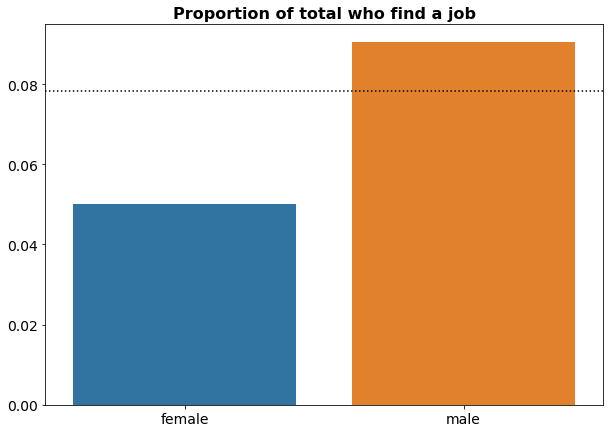

In [32]:
mean_found_job = df['found_job'].mean()

fig, ax1 = plt.subplots(figsize=(10, 7))
sns.barplot(x=agg_gender.index, y=agg_gender.found_job, ax=ax1).\
set_title('Proportion of total who find a job', fontsize=16, fontweight='bold')
ax1.axhline(mean_found_job, color='k', linestyle=':')
ax1.set(xlabel='', ylabel='')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

In [55]:
df.to_excel("df.xlsx")

Text(0.5, 1.0, 'Age vs Found or not')

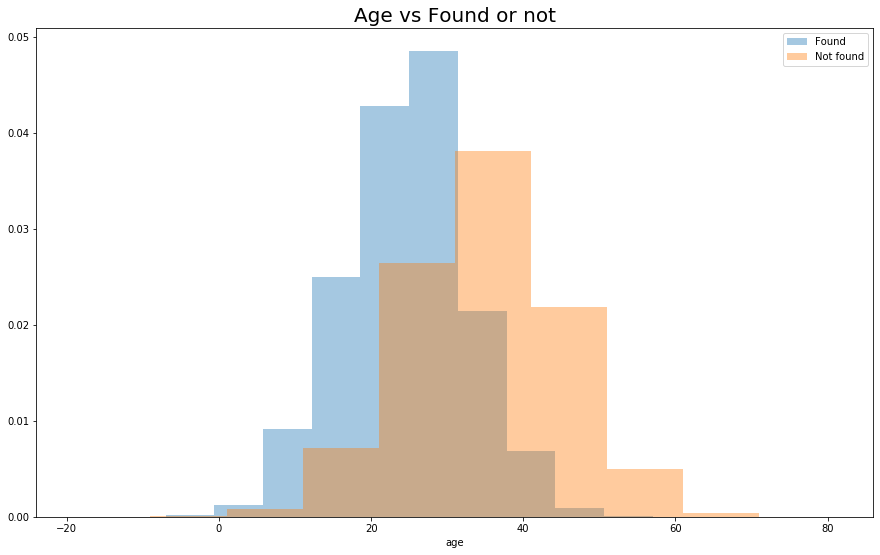

In [53]:
fig, ax = plt.subplots( figsize = (15,9) )
ax = sns.distplot(df.loc[df['found_job']==1,'age'], kde=False, bins=10, norm_hist=True, label='Found') 
ax = sns.distplot(df.loc[df['found_job']==0,'age'], kde=False, bins=10, norm_hist=True, label='Not found')
ax.legend()
ax.set_title('Age vs Found or not',fontsize = 20)

,gender,found_job
0,female,0.05
1,male,0.09


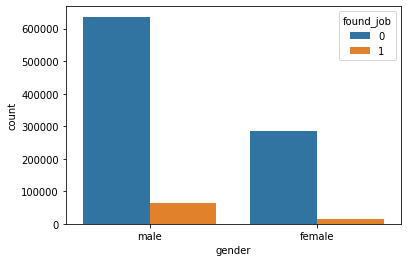

In [41]:
# 性別
sns.countplot(df['gender'], hue=df['found_job'])
display(df[['gender','found_job']].groupby(['gender'], as_index=False).mean().round(3))

In [54]:
df.groupby(['age','gender']).count()

found_job  class
age gender                  
-19 female          1      1
-16 male            1      1
-13 male            1      1
-11 female          1      1
-10 female          2      2
...               ...    ...
 77 male            8      8
 78 female          1      1
    male            2      2
 79 male            1      1
 81 male            1      1

[183 rows x 2 columns]

# 採樣並建立測試資料集

In [167]:
data = pd.read_excel('C:/Users/Administrator/paper/108_recruit_train.xlsx')
data = data[data['highest_school_level']!='F']
data['highest_school_level'] = data['highest_school_level'].replace("F","8")
data['highest_school_level'] = data['highest_school_level'].replace("Y","0")
data['highest_school_level'] = data['highest_school_level'].astype('int')
data = data.drop(['interview','second_interview','relabel_check','relabel'], axis=1)
data.head()

,id,sex,apply_age,marriage,highest_education,highest_graduation,loan,loan_status,military_status,aboriginal,height,weight,nationality,highest_school_level,english_level,hired_or_not
0,R2242YY69Y,F,24,0,B,Y,0,Y,Y,0,Y62,60,Y,3,2,N
1,R223936966,F,28,0,B,Y,Y,Y,Y,0,Y58,52,Y,2,2,N
2,F228Y6Y684,F,24,0,B,Y,Y,Y,Y,0,Y64,70,Y,3,2,N
3,O20044300Y,F,2Y,0,B,Y,0,Y,Y,0,Y52,4Y,Y,5,2,N
4,N225966272,F,22,0,B,I,0,Y,Y,0,Y55,45,Y,6,3,N


In [168]:
print("應徵總人數", len(data))
print("男性應徵人數", len(data[data['sex']=='M']))
print("男性錄取人數", len(data[(data['sex']=='M') & (data['hired_or_not']=='Y')]))
print("男性錄取率", len(data[(data['sex']=='M') & (data['hired_or_not']=='Y')])/len(data[data['sex']=='M']))
print("女性應徵人數", len(data[data['sex']=='F']))
print("女性錄取人數", len(data[(data['sex']=='F') & (data['hired_or_not']=='Y')]))
print("女性錄取率", len(data[(data['sex']=='F') & (data['hired_or_not']=='Y')])/len(data[data['sex']=='F']))
print("男性應徵人數占比",len(data[data['sex']=='M'])/len(data))
print("女性應徵人數占比",len(data[data['sex']=='F'])/len(data))

應徵總人數 1188
男性應徵人數 412
男性錄取人數 39
男性錄取率 0.09466019417475728
女性應徵人數 776
女性錄取人數 63
女性錄取率 0.08118556701030928
男性應徵人數占比 0.3468013468013468
女性應徵人數占比 0.6531986531986532


In [169]:
# 設定資料集男女比及應徵錄取比
n_pop = 1000000
p_male = 0.3468
p_job_male, p_job_female = 0.0946, 0.0812

gender = np.random.choice(['male', 'female'], size=n_pop, p=[p_male, 1 - p_male])
df = pd.DataFrame({'gender' : gender})
df.loc[df.gender == 'male', 'found_job'] = np.random.choice([1, 0], size=len(df.loc[df.gender == 'male']), p=[p_job_male, 1 - p_job_male])
df.loc[df.gender == 'female', 'found_job'] = np.random.choice([1, 0], size=len(df.loc[df.gender == 'female']), p=[p_job_female, 1 - p_job_female])
df['found_job'] = df['found_job'].astype(int)

In [170]:
# 檢視資料集
print("男性應徵人數", len(df[df['gender']=='male']))
print("男性錄取人數", len(df[(df['gender']=='male') & (df['found_job']==1)]))
print("男性錄取率", len(df[(df['gender']=='male') & (df['found_job']==1)])/len(df[df['gender']=='male']))
print("女性應徵人數", len(df[df['gender']=='female']))
print("女性錄取人數", len(df[(df['gender']=='female') & (df['found_job']==1)]))
print("女性錄取率", len(df[(df['gender']=='female') & (df['found_job']==1)])/len(df[df['gender']=='female']))
print("男性應徵人數占比",len(df[df['gender']=='male'])/len(df))
print("女性應徵人數占比",len(df[df['gender']=='female'])/len(df))

男性應徵人數 346816
男性錄取人數 32819
男性錄取率 0.09462942886141354
女性應徵人數 653184
女性錄取人數 52722
女性錄取率 0.08071538800705468
男性應徵人數占比 0.346816
女性應徵人數占比 0.653184


In [171]:
df.pivot_table(index='gender', columns='found_job', aggfunc='size')

found_job,0,1
gender,,
female,600462,52722
male,313997,32819


In [172]:
# 設定資料集年齡分布(待採樣)
mu_job, sigma_job = 28, 6
mu_no_job, sigma_no_job = 40, 10

df.loc[df.found_job == 1, 'age'] = np.floor(np.random.normal(mu_job, sigma_job, len(df.loc[df.found_job == 1])))
df.loc[df.found_job == 0, 'age'] = np.floor(np.random.normal(mu_no_job, sigma_no_job, len(df.loc[df.found_job == 0])))
df['age'] = df['age'].astype(int)

In [173]:
df.groupby('found_job').mean().round(1)

,age
found_job,
0,39.5
1,27.5


In [174]:
data['apply_age'] = data['apply_age']
# data[data['hired_or_not']=='Y'].apply_age

In [175]:
# 設定資料集學歷分布(待採樣)
print("學士人數", len(data[data['highest_education']=='B']))
print("碩士人數", len(data[data['highest_education']=='M']))
print("博士人數", len(data[data['highest_education']=='D']))
print("---------------------------------------------------------------------")
print("學士錄取人數", len(data[(data['highest_education']=='B') & (data['hired_or_not']=='Y')]))
print("碩士錄取人數", len(data[(data['highest_education']=='M') & (data['hired_or_not']=='Y')]))
print("博士錄取人數", len(data[(data['highest_education']=='D') & (data['hired_or_not']=='Y')]))
print("總錄取人數", len(data[data['hired_or_not']=='Y']))
print("---------------------------------------------------------------------")
print("學士錄取率", len(data[(data['highest_education']=='B') & (data['hired_or_not']=='Y')])/len(data[data['hired_or_not']=='Y']))
print("碩士錄取率", len(data[(data['highest_education']=='M') & (data['hired_or_not']=='Y')])/len(data[data['hired_or_not']=='Y']))
print("博士錄取率", len(data[(data['highest_education']=='D') & (data['hired_or_not']=='Y')])/len(data[data['hired_or_not']=='Y']))
print("---------------------------------------------------------------------")
print("學士不錄取率", len(data[(data['highest_education']=='B') & (data['hired_or_not']=='N')])/len(data[data['hired_or_not']=='N']))
print("碩士不錄取率", len(data[(data['highest_education']=='M') & (data['hired_or_not']=='N')])/len(data[data['hired_or_not']=='N']))
print("博士不錄取率", len(data[(data['highest_education']=='D') & (data['hired_or_not']=='N')])/len(data[data['hired_or_not']=='N']))

學士人數 1024
碩士人數 162
博士人數 2
---------------------------------------------------------------------
學士錄取人數 87
碩士錄取人數 15
博士錄取人數 0
總錄取人數 102
---------------------------------------------------------------------
學士錄取率 0.8529411764705882
碩士錄取率 0.14705882352941177
博士錄取率 0.0
---------------------------------------------------------------------
學士不錄取率 0.8627992633517495
碩士不錄取率 0.13535911602209943
博士不錄取率 0.001841620626151013


In [176]:
educ_class_set = ['B', 'M', 'D']
educ_class_wt_job = [0.8529, 0.1471, 0]
educ_class_wt_no_job = [0.8628, 0.1354, 0.0018]

df.loc[df.found_job == 1, 'educ_class'] = np.random.choice(educ_class_set, size=len(df.loc[df.found_job == 1]), p=educ_class_wt_job)
df.loc[df.found_job == 0, 'educ_class'] = np.random.choice(educ_class_set, size=len(df.loc[df.found_job == 0]), p=educ_class_wt_no_job)

In [177]:
# 檢視資料集學歷分布
print("學士人數", len(df[df['educ_class']=='B']))
print("碩士人數", len(df[df['educ_class']=='M']))
print("博士人數", len(df[df['educ_class']=='D']))
print("---------------------------------------------------------------------")
print("學士錄取人數", len(df[(df['educ_class']=='B') & (df['found_job']==1)]))
print("碩士錄取人數", len(df[(df['educ_class']=='M') & (df['found_job']==1)]))
print("博士錄取人數", len(df[(df['educ_class']=='D') & (df['found_job']==1)]))
print("總錄取人數", len(df[df['found_job']==1]))
print("---------------------------------------------------------------------")
print("學士錄取率", len(df[(df['educ_class']=='B') & (df['found_job']==1)])/len(df[df['found_job']==1]))
print("碩士錄取率", len(df[(df['educ_class']=='M') & (df['found_job']==1)])/len(df[df['found_job']==1]))
print("博士錄取率", len(df[(df['educ_class']=='D') & (df['found_job']==1)])/len(df[df['found_job']==1]))
print("---------------------------------------------------------------------")
print("學士不錄取率", len(df[(df['educ_class']=='B') & (df['found_job']==0)])/len(df[df['found_job']==0]))
print("碩士不錄取率", len(df[(df['educ_class']=='M') & (df['found_job']==0)])/len(df[df['found_job']==0]))
print("博士不錄取率", len(df[(df['educ_class']=='D') & (df['found_job']==0)])/len(df[df['found_job']==0]))

學士人數 862238
碩士人數 136134
博士人數 1628
---------------------------------------------------------------------
學士錄取人數 73043
碩士錄取人數 12498
博士錄取人數 0
總錄取人數 85541
---------------------------------------------------------------------
學士錄取率 0.8538946236307735
碩士錄取率 0.14610537636922646
博士錄取率 0.0
---------------------------------------------------------------------
學士不錄取率 0.8630184622820706
碩士不錄取率 0.13520125013805978
博士不錄取率 0.0017802875798696278


In [178]:
# 設定婚姻狀況資料分布(待採樣)
print("女性人數", len(data[data['sex']=='F']))
print("女性已婚人數", len(data[(data['sex']=='F') & (data['marriage']==1)]))
print("女性已婚占比", len(data[(data['sex']=='F') & (data['marriage']==1)])/len(data[data['sex']=='F']))
print("女性未婚人數", len(data[(data['sex']=='F') & (data['marriage']==0)]))
print("女性已婚錄取人數", len(data[(data['sex']=='F') & (data['marriage']==1) & (data['hired_or_not']=='Y')]))
print("女性未婚錄取人數", len(data[(data['sex']=='F') & (data['marriage']==0) & (data['hired_or_not']=='Y')]))
print("女性已婚族群錄取率", len(data[(data['sex']=='F') & (data['marriage']==1) & (data['hired_or_not']=='Y')])/len(data[(data['sex']=='F') & (data['marriage']==1)]))
print("女性未婚族群錄取率", len(data[(data['sex']=='F') & (data['marriage']==0) & (data['hired_or_not']=='Y')])/len(data[(data['sex']=='F') & (data['marriage']==0)]))
print("---------------------------------------------------------------------")
print("男性人數", len(data[data['sex']=='M']))
print("男性已婚人數", len(data[(data['sex']=='M') & (data['marriage']==1)]))
print("男性已婚占比", len(data[(data['sex']=='M') & (data['marriage']==1)])/len(data[data['sex']=='M']))
print("男性未婚人數", len(data[(data['sex']=='M') & (data['marriage']==0)]))
print("男性已婚錄取人數", len(data[(data['sex']=='M') & (data['marriage']==1) & (data['hired_or_not']=='Y')]))
print("男性未婚錄取人數", len(data[(data['sex']=='M') & (data['marriage']==0) & (data['hired_or_not']=='Y')]))
print("男性已婚族群錄取率", len(data[(data['sex']=='M') & (data['marriage']==1) & (data['hired_or_not']=='Y')])/len(data[(data['sex']=='M') & (data['marriage']==1)]))
print("男性未婚族群錄取率", len(data[(data['sex']=='M') & (data['marriage']==0) & (data['hired_or_not']=='Y')])/len(data[(data['sex']=='M') & (data['marriage']==0)]))

女性人數 776
女性已婚人數 95
女性已婚占比 0.12242268041237113
女性未婚人數 681
女性已婚錄取人數 3
女性未婚錄取人數 60
女性已婚族群錄取率 0.031578947368421054
女性未婚族群錄取率 0.0881057268722467
---------------------------------------------------------------------
男性人數 412
男性已婚人數 31
男性已婚占比 0.07524271844660194
男性未婚人數 381
男性已婚錄取人數 5
男性未婚錄取人數 34
男性已婚族群錄取率 0.16129032258064516
男性未婚族群錄取率 0.08923884514435695


In [179]:
# 設定男女婚姻狀況分布
p_female_marriage, p_male_marriage = 0.1224, 0.0752
df.loc[df.gender == 'male', 'marriage'] = np.random.choice([1, 0], size=len(df.loc[df.gender == 'male']), p=[p_male_marriage, 1 - p_male_marriage])
df.loc[df.gender == 'female', 'marriage'] = np.random.choice([1, 0], size=len(df.loc[df.gender == 'female']), p=[p_female_marriage, 1 - p_female_marriage])

In [199]:
# 設定婚姻狀況資料分布(待採樣)
print("女性人數", len(df[df['gender']=='female']))
print("女性已婚人數", len(df[(df['gender']=='female') & (df['marriage']==1)]))
print("女性已婚占比", len(df[(df['gender']=='female') & (df['marriage']==1)])/len(df[df['gender']=='female']))
print("女性未婚人數", len(df[(df['gender']=='female') & (df['marriage']==0)]))
print("女性已婚錄取人數", len(df[(df['gender']=='female') & (df['marriage']==1) & (df['found_job']==1)]))
print("女性未婚錄取人數", len(df[(df['gender']=='female') & (df['marriage']==0) & (df['found_job']==1)]))
print("女性已婚族群錄取率", len(df[(df['gender']=='female') & (df['marriage']==1) & (df['found_job']==1)])/len(df[(df['gender']=='female') & (df['marriage']==1)]))
print("女性未婚族群錄取率", len(df[(df['gender']=='female') & (df['marriage']==0) & (df['found_job']==1)])/len(df[(df['gender']=='female') & (df['marriage']==0)]))
print("---------------------------------------------------------------------")
print("男性人數", len(df[df['gender']=='male']))
print("男性已婚人數", len(df[(df['gender']=='male') & (df['marriage']==1)]))
print("男性已婚占比", len(df[(df['gender']=='male') & (df['marriage']==1)])/len(df[df['gender']=='male']))
print("男性未婚人數", len(df[(df['gender']=='male') & (df['marriage']==0)]))
print("男性已婚錄取人數", len(df[(df['gender']=='male') & (df['marriage']==1) & (df['found_job']==1)]))
print("男性未婚錄取人數", len(df[(df['gender']=='male') & (df['marriage']==0) & (df['found_job']==1)]))
print("男性已婚族群錄取率", len(df[(df['gender']=='male') & (df['marriage']==1) & (df['found_job']==1)])/len(df[(df['gender']=='male') & (df['marriage']==1)]))
print("男性未婚族群錄取率", len(df[(df['gender']=='male') & (df['marriage']==0) & (df['found_job']==1)])/len(df[(df['gender']=='male') & (df['marriage']==0)]))

女性人數 653184
女性已婚人數 79643
女性已婚占比 0.12193042083088379
女性未婚人數 573541
女性已婚錄取人數 6367
女性未婚錄取人數 46355
女性已婚族群錄取率 0.07994425122107404
女性未婚族群錄取率 0.08082246953574374
---------------------------------------------------------------------
男性人數 346816
男性已婚人數 25862
男性已婚占比 0.0745698007012364
男性未婚人數 320954
男性已婚錄取人數 2544
男性未婚錄取人數 30275
男性已婚族群錄取率 0.09836826231536618
男性未婚族群錄取率 0.09432815917545817


In [200]:
df.loc[df.gender == 'male', 'marriage']

0         0.0
3         0.0
5         0.0
11        0.0
12        0.0
         ... 
999984    0.0
999987    1.0
999988    0.0
999995    0.0
999996    0.0
Name: marriage, Length: 346816, dtype: float64